# Day 1: Interpretable and Explainable Machine Learning + Causal Inference

### Set up the environment

In [20]:
# Imports for handling files, data and plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Imports for methods and models
import sklearn
import xgboost  # xgboost<3
from sklearn.model_selection import train_test_split
import shap


# Set random seed for reproducibility
np.random.seed(47176870)

### Donwload and inspect the structured data

We will work with the California housing dataset. This dataset contains 20,640 observations on the average house value as target variable and 8 input variables (features): median income,
housing average age, average rooms, average bedrooms, population, average occupation, latitude, and longitude. The original data are available from StatLib http://lib.stat.cmu.edu/datasets/, or for direct download at https://ndownloader.figshare.com/files/5976036 .

References: Pace, R. K. and Barry, R. (1997). Sparse Spatial Autoregressions,Statistics and Probability Letters, 33 (1997), 291-297.

In [21]:
# Download the data set in array format from the sklearn library
housing_dataset = sklearn.datasets.fetch_california_housing(
    download_if_missing=True
)

In [22]:
# Format the "x" variable (housing prices)
X = pd.DataFrame(
    data=housing_dataset.data, columns=housing_dataset.feature_names
)

# Format the "y" variables (average income, housing average age, average rooms, average bedrooms, population, average occupation, latitude, and longitude)
y = housing_dataset.target

In [23]:
# Summarize the features using pandas
X.describe(include="all")

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [24]:
# Select a smaller subset of the data for faster processing

reduce_sample_size = False

if reduce_sample_size:
    n_points = 1000
    if n_points is not None:
        # random_state fixes the random seed for reproducibility
        X = shap.utils.sample(X, n_points, random_state=47176870)
        # random_state fixes the random seed for reproducibility
        y = shap.utils.sample(y, n_points, random_state=47176870)

### Split the data and train a model

In [25]:
# Split the data set in train and test data (20% for testing)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=47176870
)

Shallow Tree Accuracy on Train Data: 0.806533827026405
Shallow Tree Accuracy on Test Data: 0.791928575265526


Text(0.5, 1.0, 'Model Fit: True vs Predicted Housing Prices')

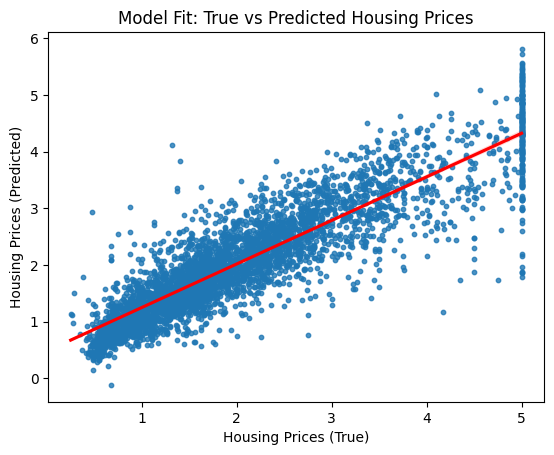

In [26]:
# Create an extreme gradient boosting model to predict the housing prices from the available features (ensemble of regression trees)

model_xgb = xgboost.XGBRegressor(
    n_estimators=100,  # number of trees
    max_depth=2,
)  # maximum depth of each tree (here we are allowing for two levels of splits: shallow trees)
# Other parameters set to default values, more information in the documentation or help(xgboost.XGBRegressor)

# Fit the model to the training data
model_xgb = model_xgb.fit(X_train, y_train)
print(
    f"Shallow Tree Accuracy on Train Data: {model_xgb.score(X_train, y_train)}"
)
print(f"Shallow Tree Accuracy on Test Data: {model_xgb.score(X_test, y_test)}")

# Plot the predictions of the model against the true values (test data)

# plt.scatter(y_test, y_pred_test)  # seen data
# plt.xlabel('Housing Prices (True)')
# plt.ylabel('Housing Prices (Predicted)')
# plt.title('Model Fit: True vs Predicted Housing Prices')

y_pred_test = model_xgb.predict(X_test)
sns.regplot(
    x=y_test, y=y_pred_test, scatter_kws={"s": 10}, line_kws={"color": "red"}
)
plt.xlabel("Housing Prices (True)")
plt.ylabel("Housing Prices (Predicted)")
plt.title("Model Fit: True vs Predicted Housing Prices")


### Explain the model with SHAP

In [27]:
# Create an "explainer" object to explain the model predictions
explainer_xgb = shap.Explainer(model_xgb, X_test)  # use the test data
# X100 = shap.utils.sample(X_test, 100)  # alternatively: restrict to 100 instances for faster computation

# Compute the SHAP values for the test data
shap_values_xgb = explainer_xgb(X_test)

### Partial dependence plot

Text(0.5, 1.0, 'Partial Dependence Plot for Average Income')

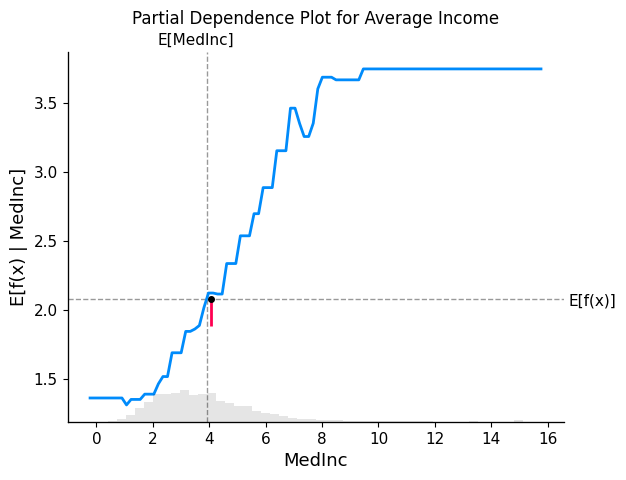

In [28]:
# Make a standard partial dependence plot with a single SHAP value overlaid

sample_ind = 20

shap.partial_dependence_plot(
    "MedInc",  # average income
    model_xgb.predict,
    X_test,
    model_expected_value=True,  # also show the expected value of the target
    feature_expected_value=True,  # also show the expected value of the feature
    show=False,
    ice=False,
    # overlay one instance in red
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
plt.title("Partial Dependence Plot for Average Income")


### Individual conditional expectation plot

Text(0.5, 1.0, 'Partial Dependence Plot for Average Income')

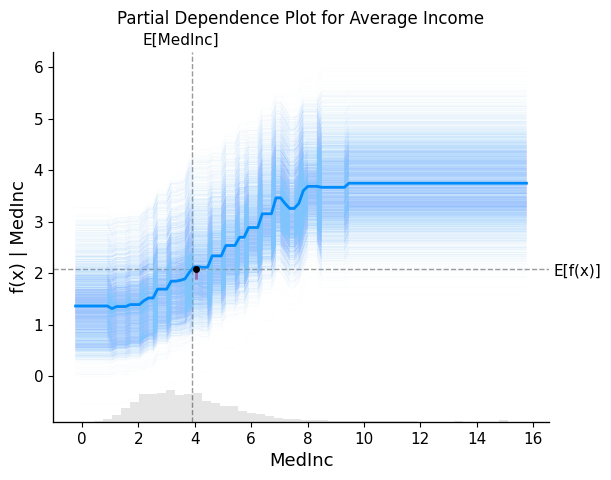

In [29]:
# Make a standard invididual conditional expectation plot with a single SHAP value overlaid

sample_ind = 20

shap.partial_dependence_plot(
    "MedInc",  # average income
    model_xgb.predict,
    X_test,
    model_expected_value=True,  # also show the expected value of the target
    feature_expected_value=True,  # also show the expected value of the feature
    show=False,
    ice=True,
    # overlay one instance in red
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)
plt.title("Partial Dependence Plot for Average Income")

### Local explanations for a single observation (similar to LIME - Local Interpretable Model-Agnostic Explanations)

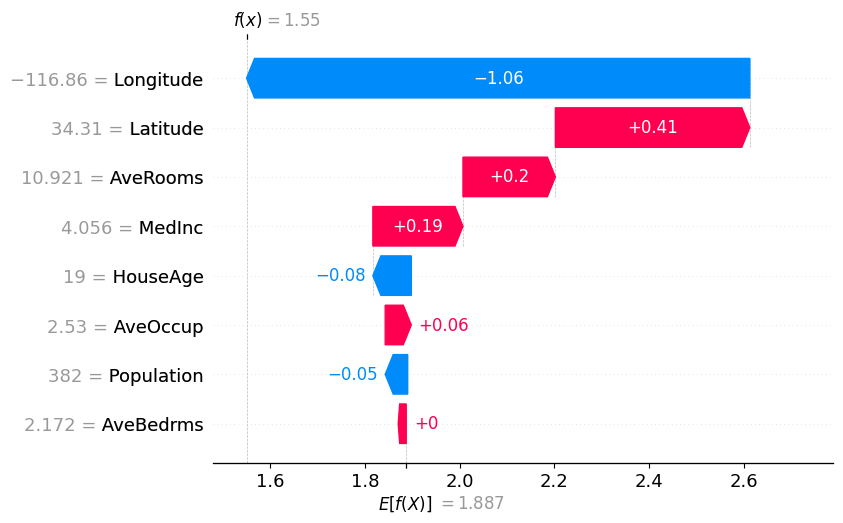

In [30]:
# Explain the model predictions for a single instance (sample_ind) using a waterfall plot
shap.plots.waterfall(shap_values_xgb[sample_ind], max_display=14)

# For observation 20 in the test data: being further west (negative longitude) has a negative effect on the predicted housing price
# Being further north (positive latitude) has a positive effect on the predicted housing price
# Having a higher number of rooms has a positive effect on predicted housing price

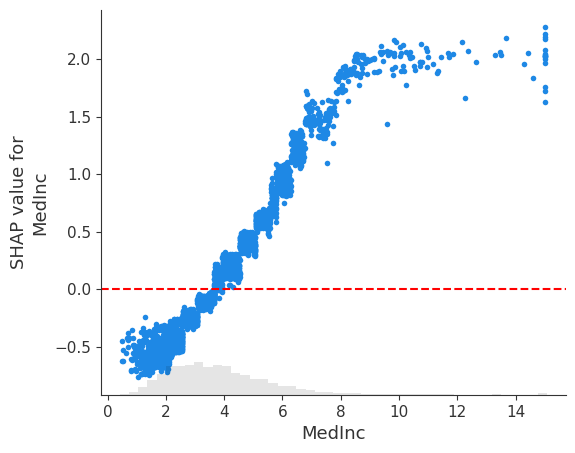

In [31]:
# Scatter plot of SHAP values for the feature "MedInc" (average income)
shap.plots.scatter(shap_values_xgb[:, "MedInc"], show=False)
plt.axhline(y=0, color="red", linestyle="--")

### Inspect interaction effects

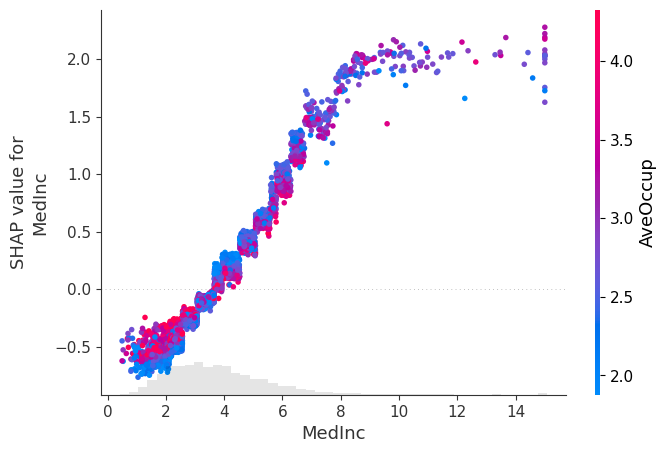

In [32]:
# Inspect interaction effecs: Plot the SHAP values for the feature "MedInc" (average income)
# against the feature "AveOccup" (average occupation)
shap.plots.scatter(
    shap_values_xgb[:, "MedInc"],
    color=shap_values_xgb[:, "AveOccup"],
)

### Explanations for several features at once

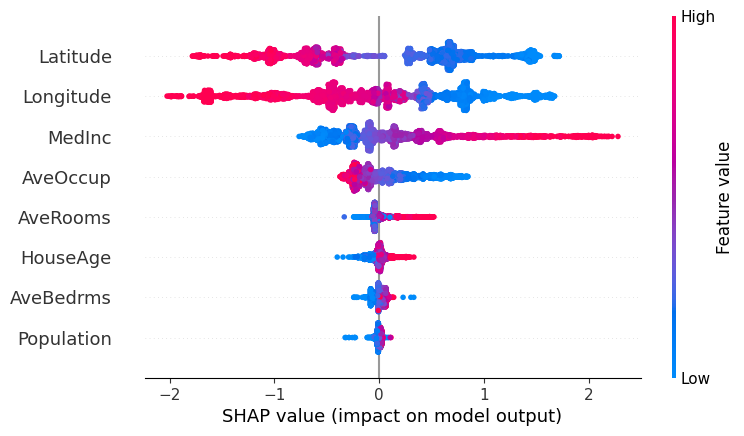

In [33]:
# Visualize several features using a beeswarm plot
shap.plots.beeswarm(shap_values_xgb)

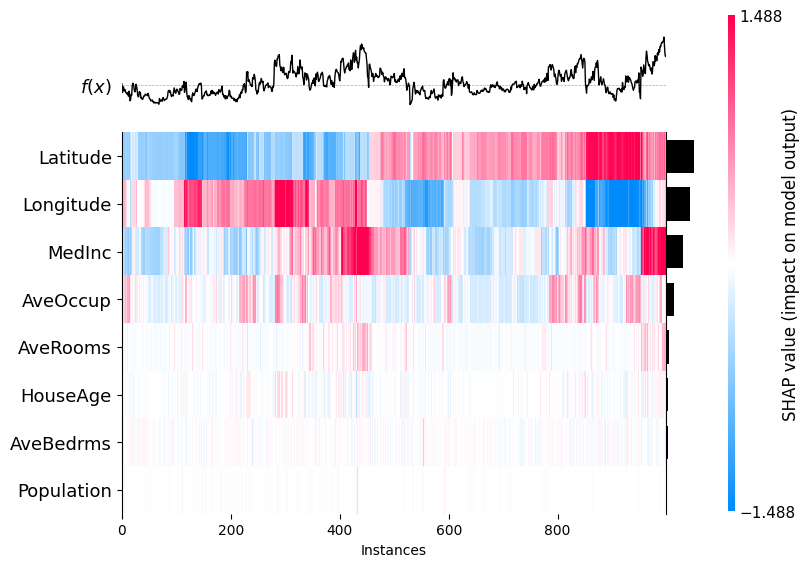

<Axes: xlabel='Instances'>

In [34]:
# Visualize several features using a heatmap
shap.plots.heatmap(shap_values_xgb[:1000])